**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Animal Dataset - v1
We will evaluate some **multiclass classification** CNNs to predict the classes of the **Animal Dataset**: https://www.kaggle.com/datasets/alessiocorrado99/animals10


Target goals:
- Proposed CNN's Architecture
- Dataset Preprocessing
    + Import the image data
    + Preprocessing the data
        - Image rescaling
        - Normalization
    + Save the preprocessed data
    + Convert the images into a _feature matrix (X)_ and a list of _target labels (y)_
- Train CNN
    - Use early stopping regularization
- Evaluate a simple CNN architecture

## 1. Set up

#### 1.1 TensorFlow

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

**GPU available?**

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.2 Fixing the seed for reproducibility (optional)
That's a try for reprodubility in Keras. See more on:
- https://stackoverflow.com/a/59076062
- https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [4]:
import os
import tensorflow as tf
import numpy as np
import random

def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    
# make some random data
reset_random_seeds()

### 1.3. Dataset
**Animal Dataset**: https://www.kaggle.com/datasets/alessiocorrado99/animals10

#### 1.3.1 Load the dataset
**Balanced dataset**: _'../datasets/animals-dataset/animals_dataset_balanced.csv'_

In [5]:
import pandas as pd

In [6]:
dataset_df = pd.read_csv('../datasets/animals-dataset/animals_dataset_balanced.csv')

In [7]:
dataset_df

,image_pathname,class
0,../datasets/animals-dataset/raw-img/cane/OIP-u...,dog
1,../datasets/animals-dataset/raw-img/cane/OIP-V...,dog
2,../datasets/animals-dataset/raw-img/cane/OIP-0...,dog
3,../datasets/animals-dataset/raw-img/cane/OIP-b...,dog
4,../datasets/animals-dataset/raw-img/cane/OIP-8...,dog
...,...,...
9995,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
9996,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
9997,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
9998,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel


#### 1.3.2 Dataset Info

In [8]:
class_names = sorted(dataset_df["class"].unique())
n_classes = len(class_names)

print(f'Number of classes: {n_classes}')
print(f'Classes: {class_names}')

Number of classes: 10
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [9]:
# number of samples per class
dataset_df['class'].value_counts()

sheep        1000
butterfly    1000
squirrel     1000
horse        1000
cat          1000
spider       1000
dog          1000
elephant     1000
cow          1000
chicken      1000
Name: class, dtype: int64

### 1.4. Split the data


Since we will _preprocess the images_, we would like to _keep the pathname_ for the **original images** just in case of recovering them. <br/>
Therefore, we will split the dataset directly from the `Pandas DataFrame`.

We will also defined a _fixed validation set_ for comparison purposes.

In [10]:
from sklearn.model_selection import train_test_split

# for a stratified sampling, we need to pass the labels
labels = dataset_df['class']

dataset_df_full_train, dataset_df_test = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=labels)

In [11]:
# for a stratified sampling, we need to pass the labels
labels_full_train = dataset_df_full_train['class']

dataset_df_train, dataset_df_val = train_test_split(dataset_df_full_train, train_size=0.8, random_state=42, stratify=labels_full_train)

In [12]:
# checking class balancing in the training set
dataset_df_train['class'].value_counts()

sheep        640
butterfly    640
squirrel     640
horse        640
cat          640
spider       640
dog          640
elephant     640
cow          640
chicken      640
Name: class, dtype: int64

In [13]:
# checking class balancing in the validation set
dataset_df_val['class'].value_counts()

cat          160
horse        160
spider       160
dog          160
elephant     160
sheep        160
cow          160
squirrel     160
butterfly    160
chicken      160
Name: class, dtype: int64

In [14]:
# checking class balancing in the training set
dataset_df_test['class'].value_counts()

cat          200
horse        200
spider       200
dog          200
elephant     200
sheep        200
cow          200
squirrel     200
butterfly    200
chicken      200
Name: class, dtype: int64

## 2. Building and Training a CNN via Keras

### 2.1 Defining the Network Architecture
That's a simple CNN for _Multiclass Classification_:
- **INPUT [64x64x3]**
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- FLATTEN
- FC [256]
- RELU
- FC [10, 'softmax']  # number of classes

- optimizer: SGD with `learning_rate=0.01`
- kernel_initializer: "glorot_uniform"
- bias_initializer: "zeros"
- **Early stopping**

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

def build_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape, activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
        MaxPool2D(pool_size=(2,2)),

        Flatten(),

        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

In [16]:
input_shape = (64, 64, 3)

model = build_cnn(input_shape, n_classes)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 256)               1

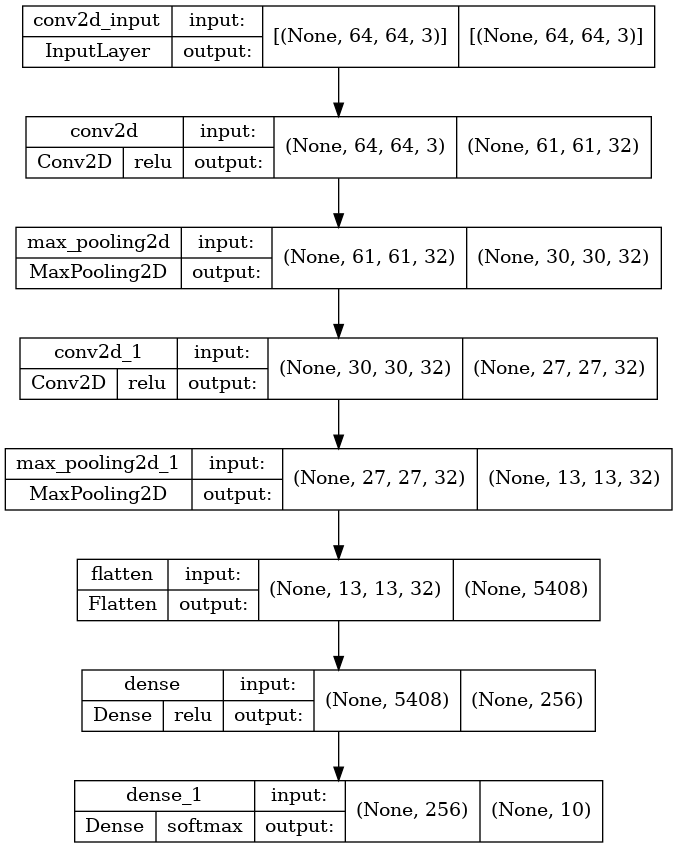

In [18]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(model, show_shapes=True, show_layer_activations=True)

### 2.2 Image Preprocessing

- **Image Resizing**
    + Since the **input layer's shape** and the **images' shape** ***are different***, we need to **resize** the images to the **input layer's shape**.
    + Let's use the function `c2.resize()` for that: https://learnopencv.com/image-resizing-with-opencv/#resize-by-wdith-height
- **Intensity (feature) Scaling**
    + Animals dataset contain 24-bit color images, i.e., it is a color image where each channel is a 8-bit grayscale image (values from 0 to 255)
    + We will simply rescale the values to [0, 1] by dividing them by 255.
- **Label Encoder**
    + Encode the string classes into class integers from 0 to n_classes-1
    + https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    
Create a function that performs all these steps.

In [19]:
import cv2
from sklearn.preprocessing import LabelEncoder


def preprocess_animals_dataset(dataset_df, label_encoder: LabelEncoder, new_dims=(64, 64)):
    # load the images as a feature matrix
    image_list = []  # list of numpy arrays
    
    for index, img_path in enumerate(dataset_df['image_pathname']):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # image resizing
        # for gray or color images, the linear interpolation sounds good
        img = cv2.resize(img, new_dims, interpolation=cv2.INTER_LINEAR)        
        image_list.append(img)
        
        # verbose - print every 1000 iterations
        if index % 1000 == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    # numpy array 4D: n_imgs, height, width, n_channels
    X = np.array(image_list)
    
    # feature scaling
    # numpy arary 4D with values within [0, 1]
    X = X / 255.0
    
    # encoding the classes
    # numpy array 1D with integer labels
    y = label_encoder.transform(dataset_df['class'])
    
    return X, y
    

In [20]:
# training a Label Encoder from the train set
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(dataset_df_train['class'])

label_encoder.classes_

array(['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse',
       'sheep', 'spider', 'squirrel'], dtype=object)

In [21]:
# preprocessing the train set
X_train, y_train = preprocess_animals_dataset(dataset_df_train, label_encoder, new_dims=(64, 64))

1/6400 - ../datasets/animals-dataset/raw-img/gallina/OIP-cKmFhr0zBKPTXF9MTKLwzgHaFj.jpeg
1001/6400 - ../datasets/animals-dataset/raw-img/cane/OIP-AEAcGy2DNHIx_uB_gi5MxgHaF7.jpeg
2001/6400 - ../datasets/animals-dataset/raw-img/elefante/OIP-BkWF1MSO6P9bsSuKTV8y2QHaEf.jpeg
3001/6400 - ../datasets/animals-dataset/raw-img/mucca/OIP-gn0PKw3rZiYzt5FPXPOAkQHaFl.jpeg
4001/6400 - ../datasets/animals-dataset/raw-img/ragno/OIP-LceMjJT43vPeDcqcanL5CgHaJ4.jpeg
5001/6400 - ../datasets/animals-dataset/raw-img/farfalla/OIP-CzG69-nGQ5fGnCiKsULvpwHaFq.jpeg
6001/6400 - ../datasets/animals-dataset/raw-img/cavallo/OIP-HgmUIneWszGNAjwv2gFJ_gHaFj.jpeg


In [22]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

X_train.shape: (6400, 64, 64, 3)
y_train (classes): [0 1 2 3 4 5 6 7 8 9]
y_train.shape: (6400,)
Min. value of X_train: 0.0
Max. value of X_train: 1.0



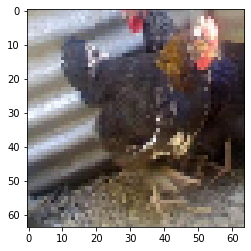

In [23]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [24]:
# preprocessing the validation set
X_val, y_val = preprocess_animals_dataset(dataset_df_val, label_encoder, new_dims=(64, 64))

1/1600 - ../datasets/animals-dataset/raw-img/ragno/OIP-HRBLjeGTfXKUkCyeLTPkxAHaFj.jpeg
1001/1600 - ../datasets/animals-dataset/raw-img/scoiattolo/OIP-IQp9NidHM365pg6ye7rmngHaG6.jpeg


In [25]:
print(f'X_val.shape: {X_val.shape}')
print(f'y_val (classes): {np.unique(y_val)}')
print(f'y_val.shape: {y_val.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_val: {X_val.min()}')
print(f'Max. value of X_val: {X_val.max()}\n')

X_val.shape: (1600, 64, 64, 3)
y_val (classes): [0 1 2 3 4 5 6 7 8 9]
y_val.shape: (1600,)
Min. value of X_val: 0.0
Max. value of X_val: 1.0



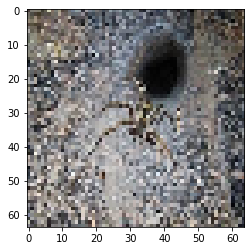

In [26]:
import matplotlib.pyplot as plt
plt.imshow(X_val[0])

In [27]:
# preprocessing the test set
X_test, y_test = preprocess_animals_dataset(dataset_df_test, label_encoder, new_dims=(64, 64))

1/2000 - ../datasets/animals-dataset/raw-img/cane/OIP-0CmAiR3-B-VLurayKj2mwAHaE8.jpeg
1001/2000 - ../datasets/animals-dataset/raw-img/ragno/OIP-lU6xdFpInas1EsyY9jbnVQEsEX.jpeg


In [28]:
print(f'X_test.shape: {X_test.shape}')
print(f'y_test (classes): {np.unique(y_test)}')
print(f'y_test.shape: {y_test.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_test: {X_test.min()}')
print(f'Max. value of X_test: {X_test.max()}\n')

X_test.shape: (2000, 64, 64, 3)
y_test (classes): [0 1 2 3 4 5 6 7 8 9]
y_test.shape: (2000,)
Min. value of X_test: 0.0
Max. value of X_test: 1.0



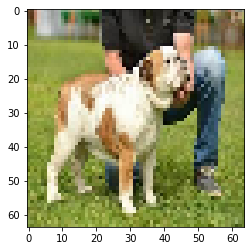

In [29]:
import matplotlib.pyplot as plt
plt.imshow(X_test[0])

Since this function may be useful in other notebooks, let's create a **python file/module** to make it available:

**File:** `animals_utils.py`

In [30]:
import animals_utils

In [31]:
# preprocessing the train set
X_train, y_train = animals_utils.preprocess_animals_dataset(dataset_df_train, label_encoder, new_dims=(64, 64))

1/6400 - ../datasets/animals-dataset/raw-img/gallina/OIP-cKmFhr0zBKPTXF9MTKLwzgHaFj.jpeg
1001/6400 - ../datasets/animals-dataset/raw-img/cane/OIP-AEAcGy2DNHIx_uB_gi5MxgHaF7.jpeg
2001/6400 - ../datasets/animals-dataset/raw-img/elefante/OIP-BkWF1MSO6P9bsSuKTV8y2QHaEf.jpeg
3001/6400 - ../datasets/animals-dataset/raw-img/mucca/OIP-gn0PKw3rZiYzt5FPXPOAkQHaFl.jpeg
4001/6400 - ../datasets/animals-dataset/raw-img/ragno/OIP-LceMjJT43vPeDcqcanL5CgHaJ4.jpeg
5001/6400 - ../datasets/animals-dataset/raw-img/farfalla/OIP-CzG69-nGQ5fGnCiKsULvpwHaFq.jpeg
6001/6400 - ../datasets/animals-dataset/raw-img/cavallo/OIP-HgmUIneWszGNAjwv2gFJ_gHaFj.jpeg


In [32]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

X_train.shape: (6400, 64, 64, 3)
y_train (classes): [0 1 2 3 4 5 6 7 8 9]
y_train.shape: (6400,)
Min. value of X_train: 0.0
Max. value of X_train: 1.0



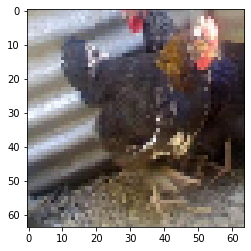

In [33]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

#### **Observation**

While _image resizing_ and _feature scaling_ **don't learn** any parameter, our _label encoding_ learns the convertion between _class names_ to _sequential integers_ considering the **entire data**. <br/>
To consider a _real scenario_, we shouldn't do that. We should _split the data_ into _training and testing sets_ ***before* applying any preprocessing** to avoid _snooping bias_. <br/>

One better way is to create a **Scikit-learn `Pipeline`** to _preprocess our data_. For that, we would have to create a _custom sklearn transformer_ to resize the images as well as for the simple feature normalization, and label encoding. Then, we could use this **preprocessing step** in production to preprocess any data!

Another way is consider the _preprocessing steps_ as **layers** from your Neural Network: https://www.tensorflow.org/tutorials/images/data_augmentation

### 2.3 Save the preprocessed data

In [34]:
import os

out_dir = '../datasets/animals-dataset/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
dataset_df_full_train.to_csv(os.path.join(out_dir, 'full_train.csv'), index=False)

dataset_df_train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)
np.save(os.path.join(out_dir, 'train_data_64x64x3.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

dataset_df_val.to_csv(os.path.join(out_dir, 'validation.csv'), index=False)
np.save(os.path.join(out_dir, 'validation_data_64x64x3.npy'), X_val)
np.save(os.path.join(out_dir, 'validation_labels.npy'), y_val)

dataset_df_test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)
np.save(os.path.join(out_dir, 'test_data_64x64x3.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)

### 2.5 Training with Early Stopping

In case of GPU drivers, we can monitor its use by [_gpustat_](https://github.com/wookayin/gpustat).

On terminal, use: `gpustat -cpi`


In [35]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [36]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
200/200 [==============================] - 3s 5ms/step - loss: 2.2864 - accuracy: 0.1353 - val_loss: 2.2670 - val_accuracy: 0.1688
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 2.2299 - accuracy: 0.1905 - val_loss: 2.1852 - val_accuracy: 0.2212
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 2.1275 - accuracy: 0.2350 - val_loss: 2.1354 - val_accuracy: 0.2000
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 2.0252 - accuracy: 0.2808 - val_loss: 2.0371 - val_accuracy: 0.2469
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 1.9296 - accuracy: 0.3134 - val_loss: 1.9152 - val_accuracy: 0.3131
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 1.8534 - accuracy: 0.3487 - val_loss: 1.8762 - val_accuracy: 0.3400
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 1.7828 - accuracy: 0.3748 - val_loss: 1.7810 - val_accuracy: 0.3594

#### **Visualizing the training history**

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Score')

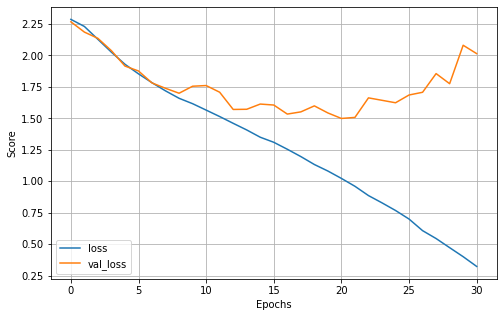

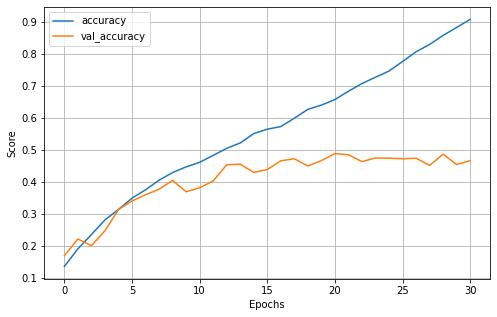

In [39]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

## 3. Evaluating and Predicting New Samples by using our Overfitted Model

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [40]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 1.4931 - accuracy: 0.5050


[1.4931435585021973, 0.5049999952316284]

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [41]:
y_test_proba = model.predict(X_test)
y_test_proba

array([[3.42726533e-04, 2.73997849e-03, 5.08308643e-03, ...,
        4.94344205e-01, 1.70498402e-04, 7.94301217e-04],
       [4.18427771e-05, 9.08654532e-04, 3.68098481e-05, ...,
        3.39858350e-04, 1.24386526e-04, 1.18608645e-04],
       [6.99841790e-03, 1.00918617e-02, 4.04453725e-02, ...,
        3.88722122e-01, 7.57681992e-05, 4.44368631e-01],
       ...,
       [5.36107877e-03, 1.49773648e-02, 9.49360073e-01, ...,
        2.17444147e-03, 1.01040287e-05, 1.78254545e-02],
       [8.53866637e-01, 3.53066996e-03, 7.57107104e-04, ...,
        1.47844218e-02, 1.22930534e-01, 2.88185501e-03],
       [7.16107385e-03, 8.17252398e-01, 2.83375103e-03, ...,
        4.99321520e-03, 6.12648278e-02, 6.45243600e-02]], dtype=float32)

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [42]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([7, 5, 9, ..., 2, 0, 1])

In [43]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

              precision    recall  f1-score   support

   butterfly       0.84      0.64      0.73       200
         cat       0.46      0.49      0.48       200
     chicken       0.59      0.46      0.52       200
         cow       0.44      0.51      0.47       200
         dog       0.40      0.26      0.32       200
    elephant       0.56      0.55      0.55       200
       horse       0.53      0.45      0.49       200
       sheep       0.38      0.59      0.46       200
      spider       0.54      0.65      0.59       200
    squirrel       0.46      0.45      0.45       200

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.52      0.51      0.50      2000



We got a **poor accuracy** of 0.51.

#### **Visualizing some misclassified image**

In [44]:
y_test_class_name = label_encoder.inverse_transform(y_test)
y_test_pred_class_name = label_encoder.inverse_transform(y_test_pred)

In [45]:
misclassification_mask = y_test_class_name != y_test_pred_class_name

**Sheep**

In [46]:
sheep_error_mask = misclassification_mask & (y_test_class_name == "sheep")

np.argwhere(sheep_error_mask)[:3]

array([[ 9],
       [18],
       [30]])

Text(0.5, 1.0, 'True: sheep, Predicted: cow')

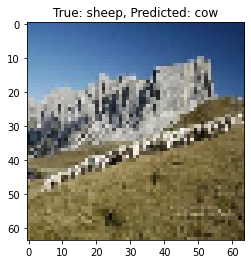

In [47]:
img_idx = 9

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

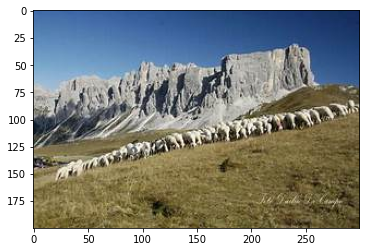

In [48]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Text(0.5, 1.0, 'True: sheep, Predicted: spider')

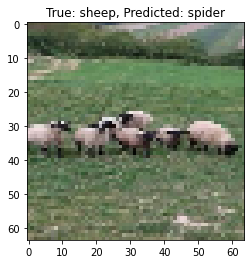

In [49]:
img_idx = 18

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

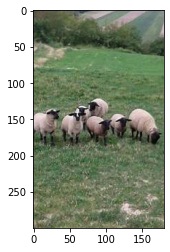

In [50]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

**Dog**

In [51]:
dog_error_mask = misclassification_mask & (y_test_class_name == "dog")

np.argwhere(dog_error_mask)[:3]

array([[ 0],
       [13],
       [31]])

Text(0.5, 1.0, 'True: dog, Predicted: sheep')

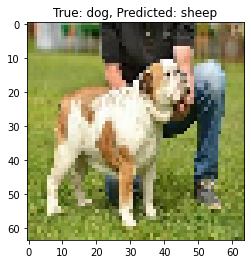

In [52]:
img_idx = 0

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

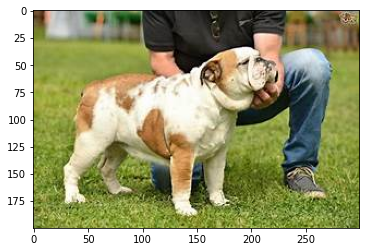

In [53]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Text(0.5, 1.0, 'True: dog, Predicted: squirrel')

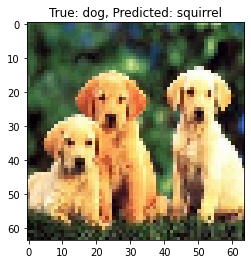

In [54]:
img_idx = 13

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

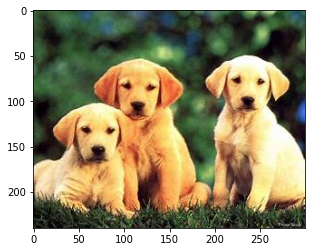

In [55]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Exercise

Repeat the experiments considering different:
-  values for _learning_rate_ of SGD
- optimizers (e.g., 'nadam')
- kernel regularizer (e.g., 'l2')
- Dropout regularization